 Ensemble Prediction and Decision Tree Model Evaluation

1. Load and Preprocess Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

file_path = "/content/drive/MyDrive/wdbc.data"

# Format: ID, Diagnosis(M=malignant, B=benign), 30 features
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv(file_path, header=None, names=columns)

# Drop ID (not useful for prediction)
df = df.drop("ID", axis=1)

# Encode target labels (M=1 malignant, B=0 benign)
label_encoder = LabelEncoder()
df["Diagnosis"] = label_encoder.fit_transform(df["Diagnosis"])

# Separate features & target
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Dataset loaded and preprocessed successfully!")
print("Shape of X:", X.shape)
print("Class distribution:\n", y.value_counts())

Mounted at /content/drive
✅ Dataset loaded and preprocessed successfully!
Shape of X: (569, 30)
Class distribution:
 Diagnosis
0    357
1    212
Name: count, dtype: int64


2. EDA (Class Balance & Feature Correlation)

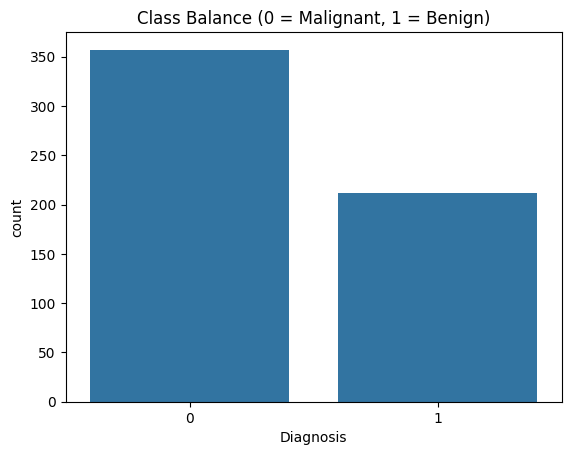

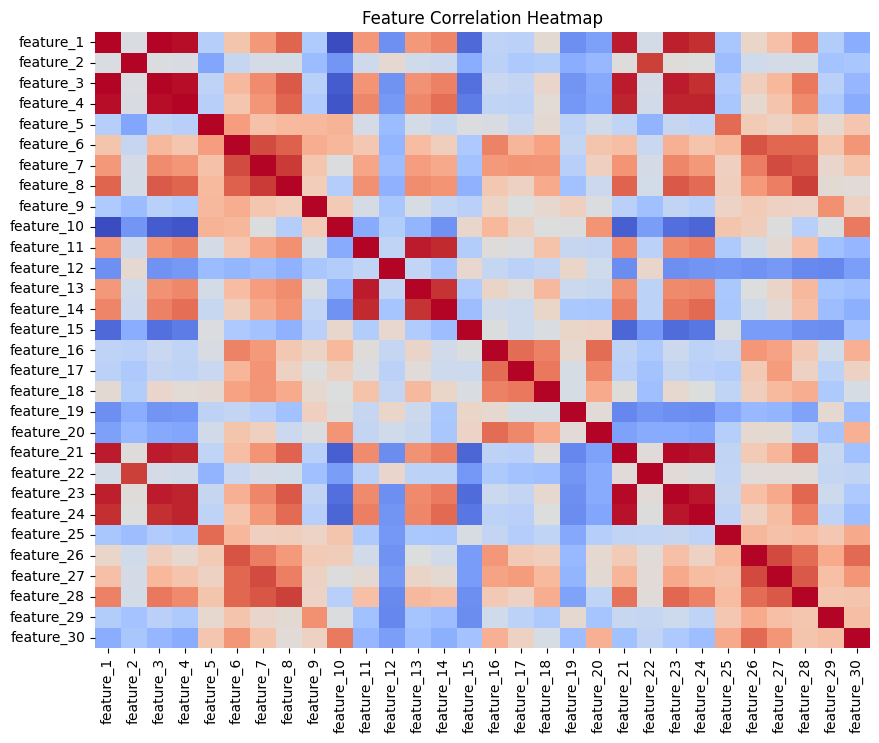

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class balance
sns.countplot(x=y)
plt.title("Class Balance (0 = Malignant, 1 = Benign)")
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()

3. Split Dataset (Train, Validation, Test)

In [3]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42, stratify=y_train_valid)
# 60% train, 20% validation, 20% test

4. Train Models

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, random_state=42)),
            ("nb", GaussianNB()),
            ("dt", DecisionTreeClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

 5. Hyperparameter Tuning with GridSearchCV
 6. 5-Fold Cross-Validation

In [5]:
param_grids = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "gamma": [0, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "criterion": ["gini", "entropy"],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [2, 5]
    },
    "Stacking": {
        "final_estimator": [LogisticRegression(), RandomForestClassifier(n_estimators=100)]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_valid, y_valid)
    best_models[name] = grid.best_estimator_
    print(f"Best Params: {grid.best_params_}")


🔍 Tuning Decision Tree...
Best Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}

🔍 Tuning AdaBoost...
Best Params: {'learning_rate': 1.0, 'n_estimators': 200}

🔍 Tuning Gradient Boosting...
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

🔍 Tuning XGBoost...
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

🔍 Tuning Random Forest...
Best Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

🔍 Tuning Stacking...
Best Params: {'final_estimator': RandomForestClassifier()}


7. ROC Curves & Metrics on Test Data


Decision Tree | Accuracy: 0.9035, F1: 0.8571, AUC: 0.8750
Confusion Matrix:
 [[70  2]
 [ 9 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        72
           1       0.94      0.79      0.86        42

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114


AdaBoost | Accuracy: 0.9737, F1: 0.9630, AUC: 0.9871
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


Gradient Boosting | Accuracy: 0.9649, F1: 0.9500, AUC: 0.9970
Confusion Matrix:
 [[72  0]
 [ 4 38]]
Classifi

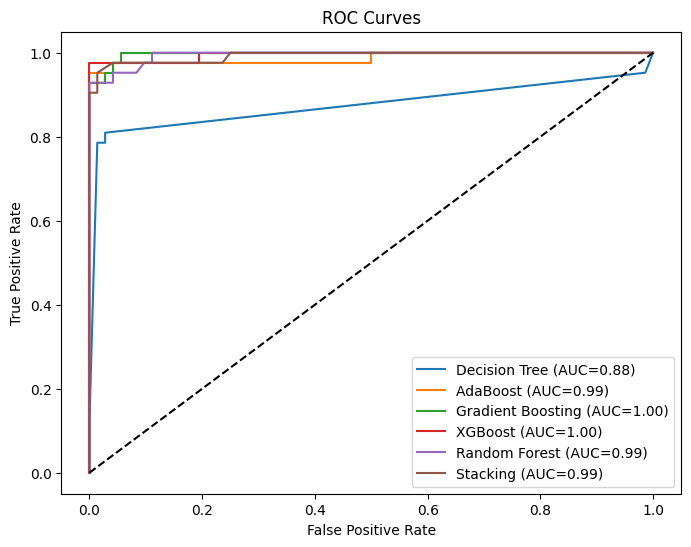

In [6]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

plt.figure(figsize=(8,6))
for name, model in best_models.items():
    model.fit(X_train_valid, y_train_valid)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"\n{name} | Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [7]:
for name, model in best_models.items():
    print("Confusion Matrix of ",{name},":\n", confusion_matrix(y_test, y_pred))

Confusion Matrix of  {'Decision Tree'} :
 [[71  1]
 [ 4 38]]
Confusion Matrix of  {'AdaBoost'} :
 [[71  1]
 [ 4 38]]
Confusion Matrix of  {'Gradient Boosting'} :
 [[71  1]
 [ 4 38]]
Confusion Matrix of  {'XGBoost'} :
 [[71  1]
 [ 4 38]]
Confusion Matrix of  {'Random Forest'} :
 [[71  1]
 [ 4 38]]
Confusion Matrix of  {'Stacking'} :
 [[71  1]
 [ 4 38]]


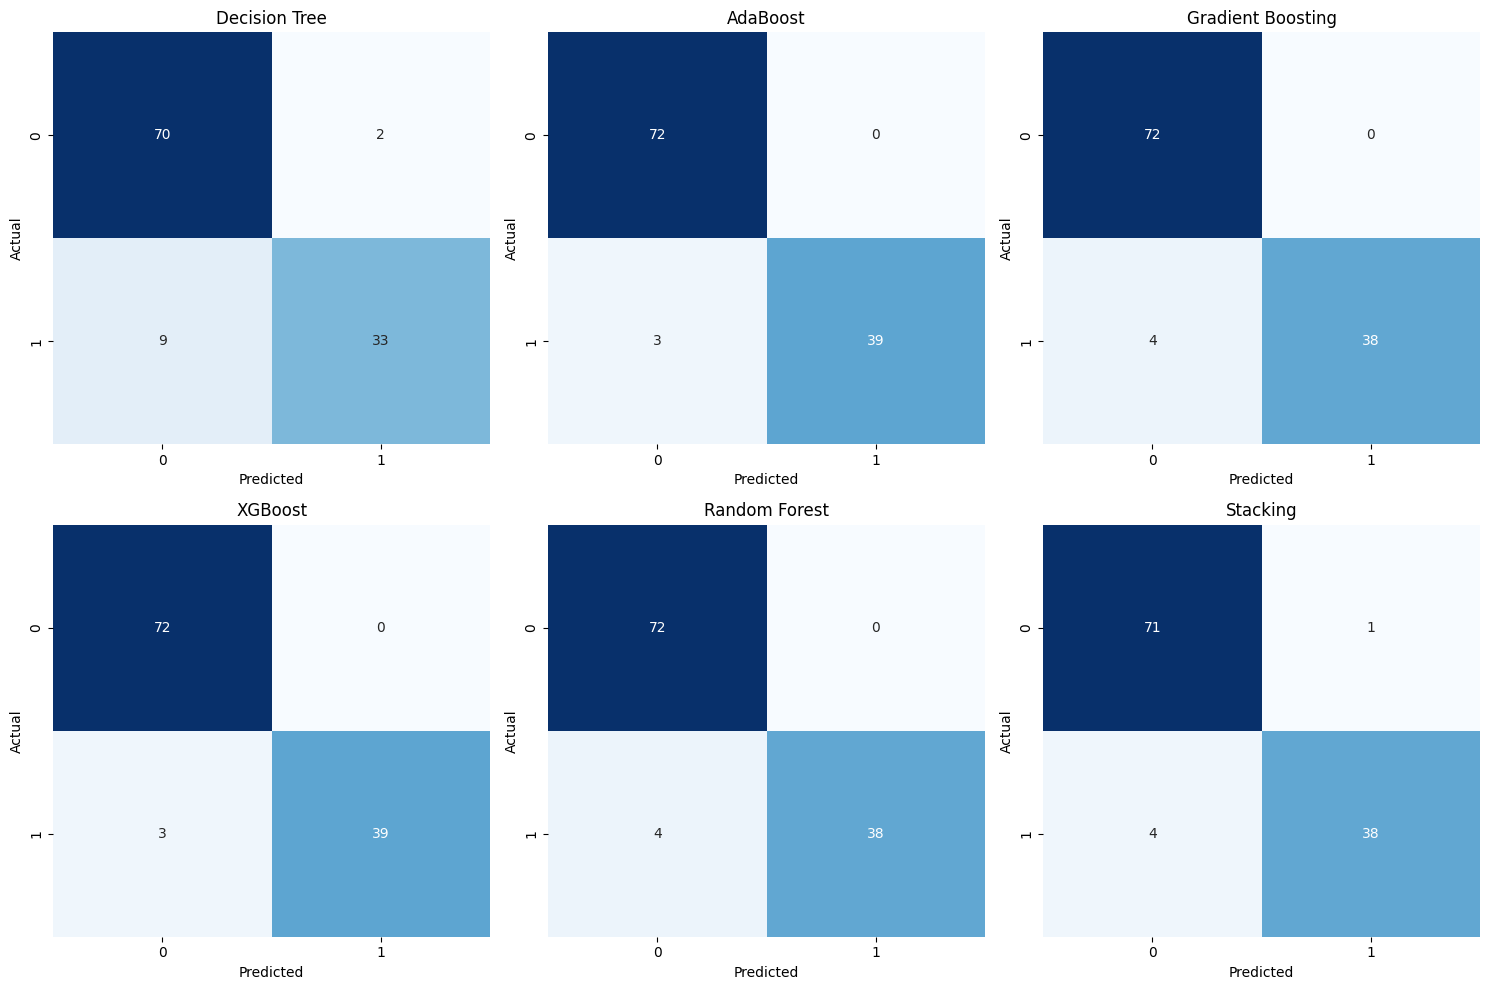

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax, (name, model) in zip(axes.flatten(), best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


/tmp/ipython-input-256981489.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances[rf_indices][:15], y=X.columns[rf_indices][:15], palette="viridis")


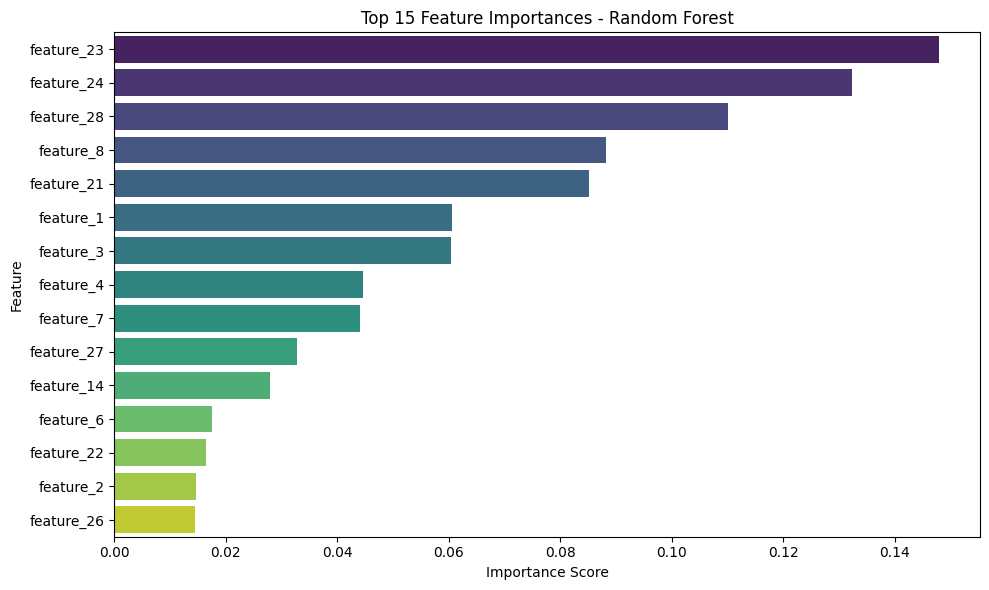

/tmp/ipython-input-256981489.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances[xgb_indices][:15], y=X.columns[xgb_indices][:15], palette="magma")


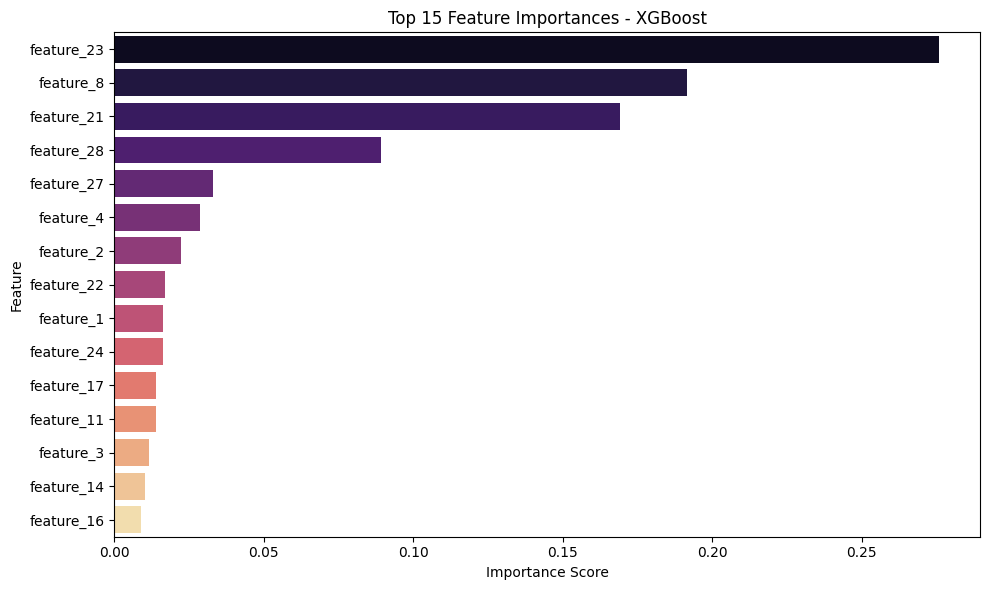

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Random Forest Feature Importance ---
rf_model = best_models["Random Forest"]

rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances[rf_indices][:15], y=X.columns[rf_indices][:15], palette="viridis")
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance_rf.png")
plt.show()

# --- XGBoost Feature Importance ---
xgb_model = best_models["XGBoost"]

xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances[xgb_indices][:15], y=X.columns[xgb_indices][:15], palette="magma")
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance_xgb.png")
plt.show()


In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define 5-fold CV (on training set only)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in best_models.items():
    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

    results[name] = {
        "Accuracy": acc_scores,
        "F1": f1_scores,
        "AUC": auc_scores
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name}")
    print(f"  Accuracy folds: {metrics['Accuracy']} | Avg = {metrics['Accuracy'].mean():.4f}")
    print(f"  F1 folds:       {metrics['F1']} | Avg = {metrics['F1'].mean():.4f}")
    print(f"  AUC folds:      {metrics['AUC']} | Avg = {metrics['AUC'].mean():.4f}")



Decision Tree
  Accuracy folds: [0.92753623 0.97058824 0.97058824 0.94117647 0.95588235] | Avg = 0.9532
  F1 folds:       [0.90196078 0.96296296 0.96       0.92307692 0.94117647] | Avg = 0.9378
  AUC folds:      [0.88774597 0.97619048 0.96930233 0.95348837 0.97348837] | Avg = 0.9520

AdaBoost
  Accuracy folds: [0.92753623 0.98529412 1.         0.98529412 1.        ] | Avg = 0.9796
  F1 folds:       [0.89795918 0.98113208 1.         0.97959184 1.        ] | Avg = 0.9717
  AUC folds:      [0.98300537 1.         1.         0.97860465 1.        ] | Avg = 0.9923

Gradient Boosting
  Accuracy folds: [0.94202899 0.95588235 0.98529412 0.98529412 0.95588235] | Avg = 0.9649
  F1 folds:       [0.91666667 0.94339623 0.97959184 0.97959184 0.94117647] | Avg = 0.9521
  AUC folds:      [0.96243292 0.99450549 1.         0.99023256 0.9972093 ] | Avg = 0.9889

XGBoost
  Accuracy folds: [0.94202899 0.98529412 0.98529412 0.98529412 0.98529412] | Avg = 0.9766
  F1 folds:       [0.91666667 0.98113208 0.9795

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid


def make_table(model, param_grid, columns, X, y):
    rows = []
    for params in ParameterGrid(param_grid):
        clf = model.set_params(**params)
        acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy").mean()
        f1 = cross_val_score(clf, X, y, cv=5, scoring="f1").mean()
        row = {col: params.get(col, "") for col in columns}
        row["Accuracy"] = round(acc, 4)
        row["F1 Score"] = round(f1, 4)
        rows.append(row)
    return pd.DataFrame(rows, columns=columns+["Accuracy","F1 Score"])

# ---- Table 1: Decision Tree ----
dt_table = make_table(models["Decision Tree"], param_grids["Decision Tree"],
                      ["criterion","max_depth"], X_train_valid, y_train_valid)

# ---- Table 2: AdaBoost ----
ada_table = make_table(models["AdaBoost"], param_grids["AdaBoost"],
                       ["n_estimators","learning_rate"], X_train_valid, y_train_valid)

# ---- Table 3: Gradient Boosting ----
gb_table = make_table(models["Gradient Boosting"], param_grids["Gradient Boosting"],
                      ["n_estimators","learning_rate","max_depth"], X_train_valid, y_train_valid)

# ---- Table 4: XGBoost ----
xgb_table = make_table(models["XGBoost"], param_grids["XGBoost"],
                       ["n_estimators","learning_rate","max_depth","gamma"], X_train_valid, y_train_valid)

# ---- Table 5: Random Forest ----
rf_table = make_table(models["Random Forest"], param_grids["Random Forest"],
                      ["n_estimators","max_depth","criterion"], X_train_valid, y_train_valid)

# ---- Table 6: Stacked Ensemble ----
stack_table = make_table(models["Stacking"], param_grids["Stacking"],
                         ["final_estimator"], X_train_valid, y_train_valid)

# Show all tables
print("\n📊 Table 1: Decision Tree")
display(dt_table)
print("\n📊 Table 2: AdaBoost")
display(ada_table)
print("\n📊 Table 3: Gradient Boosting")
display(gb_table)
print("\n📊 Table 4: XGBoost")
display(xgb_table)
print("\n📊 Table 5: Random Forest")
display(rf_table)
print("\n📊 Table 6: Stacked Ensemble")
display(stack_table)
